In [49]:
import numpy as np
import pandas as pd
import os
from keras.preprocessing import image
import matplotlib.pyplot as plt

In [33]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [50]:
image_path="/content/drive/MyDrive/Dataset"
train_images = sorted(os.listdir(image_path))

train_image = []
for im in train_images:
    img_path = os.path.join(image_path, im)
    img = image.load_img(img_path, target_size=(64, 64), color_mode='grayscale')
    img = image.img_to_array(img)
    img = img / 255
    train_image.append(img)

train_df = np.array(train_image)


In [51]:
def show_img(dataset):
    f, ax = plt.subplots(1,5)
    f.set_size_inches(40, 20)
    for i in range(5,10):
        ax[i-5].imshow(dataset[i].reshape(64,64), cmap='gray')
    plt.show()

In [52]:
def add_noice(image):
    row,col,ch= image.shape
    mean = 0
    sigma = 1
    gauss = np.random.normal(mean,sigma,(row,col,ch))
    gauss = gauss.reshape(row,col,ch)
    noisy = image + gauss*0.07
    return noisy

In [53]:
noised_df= []

for img in train_df:
    noisy= add_noice(img)
    noised_df.append(noisy)
noised_df= np.array(noised_df)

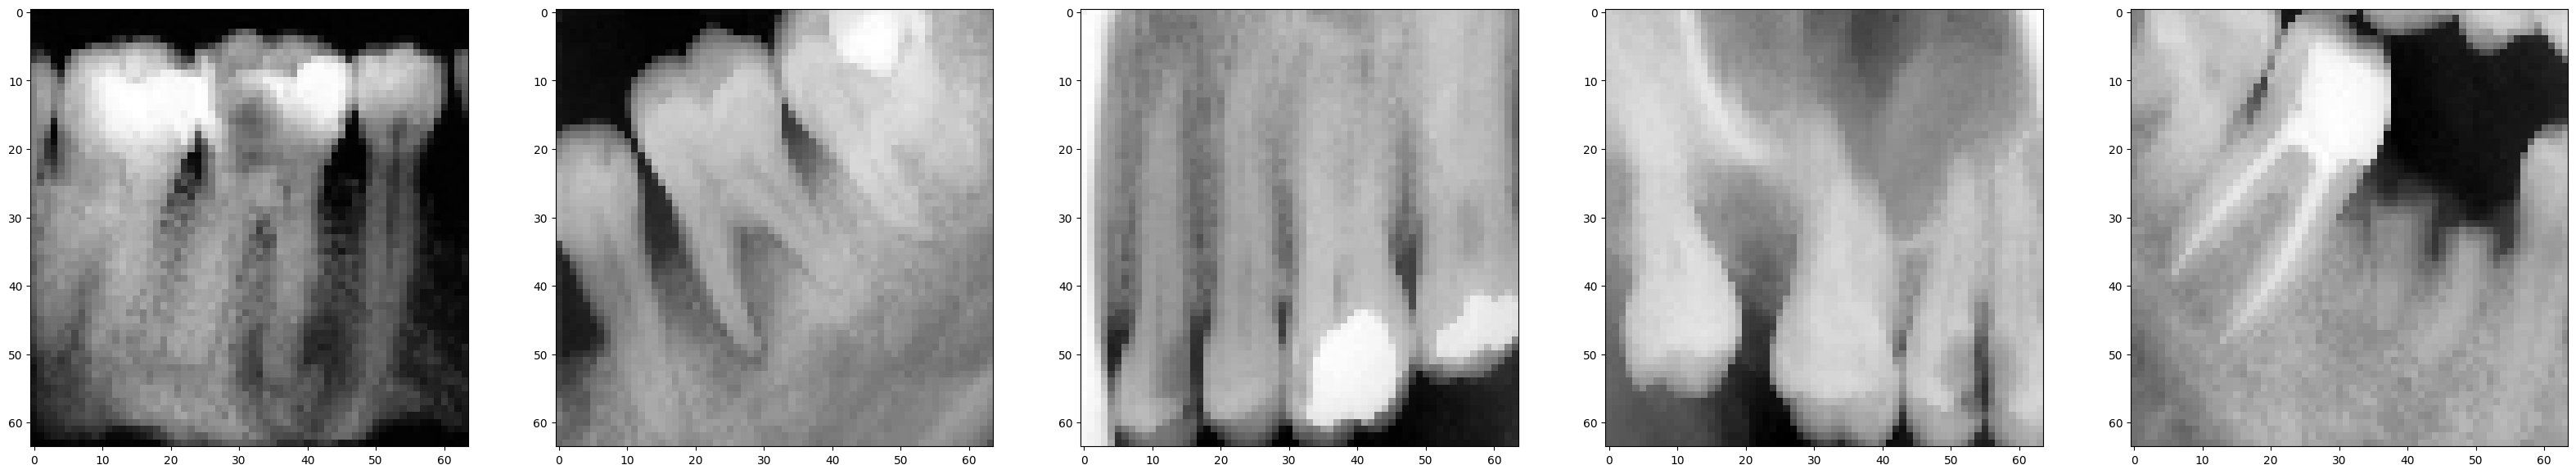

In [54]:
show_img(train_df)

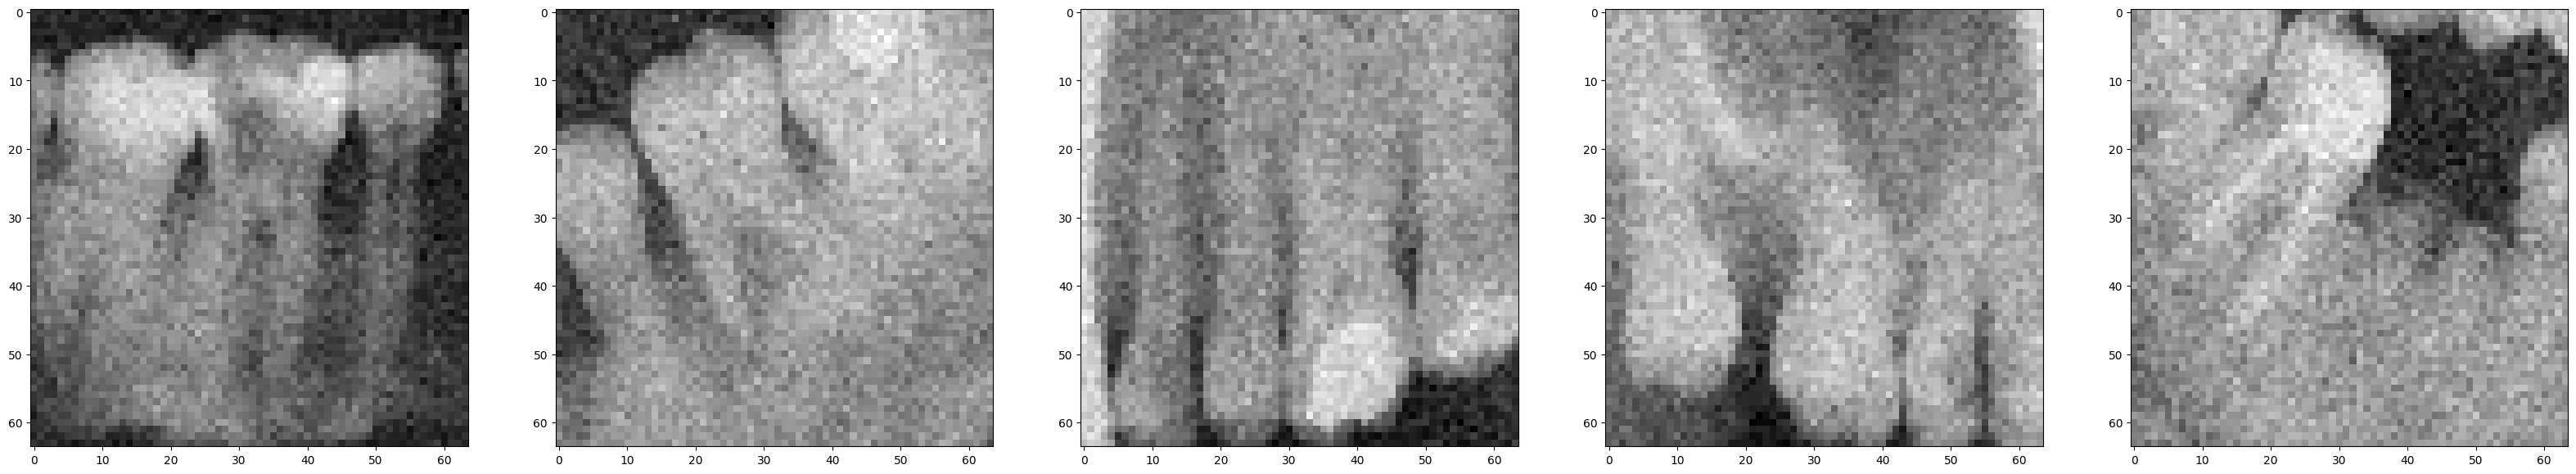

In [55]:
show_img(noised_df)

In [56]:
noised_df.shape
train_df.shape
xnoised= noised_df[0:100]
xtest= noised_df[100:]
xnoised.shape

(100, 64, 64, 1)

In [57]:
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPooling2D,MaxPool2D ,UpSampling2D, Flatten, Input
from keras.optimizers import SGD, Adam, Adadelta, Adagrad
from keras import backend as K

In [58]:
def autoencoder():

    input_img = Input(shape=(64,64,1), name='image_input')

    #enoder
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1')(input_img)
    x = MaxPooling2D((2,2), padding='same', name='pool1')(x)
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv2')(x)
    x = MaxPooling2D((2,2), padding='same', name='pool2')(x)

    #decoder
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv3')(x)
    x = UpSampling2D((2,2), name='upsample1')(x)
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv4')(x)
    x = UpSampling2D((2,2), name='upsample2')(x)
    x = Conv2D(1, (3,3), activation='sigmoid', padding='same', name='Conv5')(x)

    #model
    autoencoder = Model(inputs=input_img, outputs=x)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

    return autoencoder

In [59]:
model= autoencoder()
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_input (InputLayer)    [(None, 64, 64, 1)]       0         
                                                                 
 Conv1 (Conv2D)              (None, 64, 64, 64)        640       
                                                                 
 pool1 (MaxPooling2D)        (None, 32, 32, 64)        0         
                                                                 
 Conv2 (Conv2D)              (None, 32, 32, 64)        36928     
                                                                 
 pool2 (MaxPooling2D)        (None, 16, 16, 64)        0         
                                                                 
 Conv3 (Conv2D)              (None, 16, 16, 64)        36928     
                                                                 
 upsample1 (UpSampling2D)    (None, 32, 32, 64)        0   

In [60]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
with tf.device('/device:GPU:0'):
    early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')
    model.fit(xnoised, xnoised, epochs=40, batch_size=10, validation_data=(xtest, xtest), callbacks=[early_stopping])

1/1 [==============================] - 0s 88ms/step


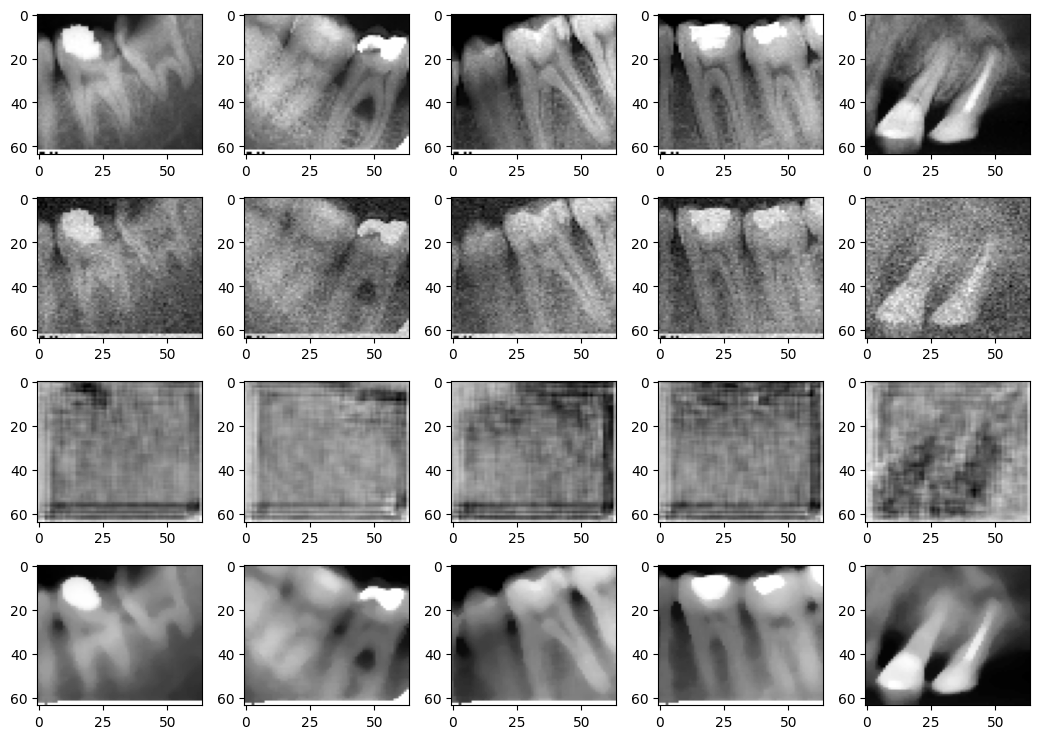

In [61]:
xtrain= train_df[100:]
import cv2

pred= model.predict(xtest[:5])
def plot_predictions(y_true, y_pred):
    f, ax = plt.subplots(4, 5)
    f.set_size_inches(10.5,7.5)
    for i in range(5):
        ax[0][i].imshow(np.reshape(xtrain[i], (64,64)), aspect='auto', cmap='gray')
        ax[1][i].imshow(np.reshape(y_true[i], (64,64)), aspect='auto', cmap='gray')
        ax[2][i].imshow(np.reshape(y_pred[i], (64,64)), aspect='auto', cmap='gray')
        ax[3][i].imshow(cv2.medianBlur(xtrain[i], (5)), aspect='auto', cmap='gray')

    plt.tight_layout()
plot_predictions(xtest[:5], pred[:5])

In [62]:
from math import log10, sqrt

def PSNR(original, denoiced):
    mse = np.mean((original - denoiced) ** 2)
    if(mse == 0):
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr

value1 = PSNR(xtest[0], new_image)
value2 = PSNR(xtest[0], pred[0])

print(f"PSNR value for Denoised image is {value2} dB while for Median filtered image is {value1} dB")

PSNR value for Denoised image is 60.821801183532756 dB while for Median filtered image is 58.498041392403906 dB


1/1 [==============================] - 0s 36ms/step


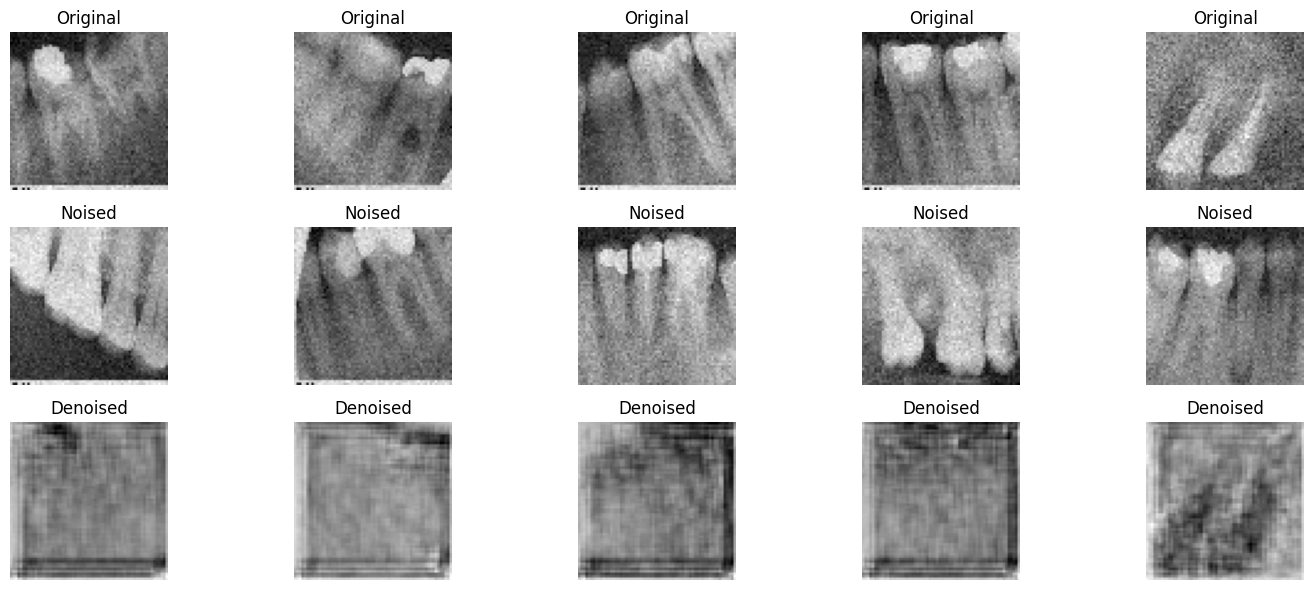

In [63]:
sample_images = xtest[:5]


denoised_images = model.predict(sample_images)

plt.figure(figsize=(15, 6))
for i in range(5):

    plt.subplot(3, 5, i+1)
    plt.imshow(sample_images[i].reshape(64, 64), cmap='gray')
    plt.title('Original')
    plt.axis('off')


    plt.subplot(3, 5, i+6)
    plt.imshow(noised_df[i].reshape(64, 64), cmap='gray')
    plt.title('Noised')
    plt.axis('off')


    plt.subplot(3, 5, i+11)
    plt.imshow(denoised_images[i].reshape(64, 64), cmap='gray')
    plt.title('Denoised')
    plt.axis('off')

plt.tight_layout()
plt.show()